# Comparative Analysis of SIFT/BoW, CNNs, and SSL Techniques for Image Classification - **Data Preprocessing**
Supervised Learning A.Y 2023/24 \
_Alessio De Luca 919790_ |
_Simone Vaccari 915222_  |
_Davide Vettore 868855_

## Libraries

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import random
from PIL import Image
import glob

from sklearn.model_selection import train_test_split
from torchvision import transforms

## Data loading and train-val-test split

In [ ]:
# Define root directory path
path = "/kaggle/input/"

# Define image paths
train_path = path + "train_set/train_set/*.jpg"
val_path = path + "val_set/val_set/*.jpg"

# Lists with the paths of each image SORTED
train_paths = glob.glob(train_path)
val_paths = glob.glob(val_path)

train_paths = sorted([path[-16:] for path in train_paths])
val_paths = sorted([path[-14:] for path in val_paths])

# Dfs with the labels SORTED
train_labels_df = pd.read_csv(path + "train_labels.csv")
val_labels_df = pd.read_csv(path + "val_labels.csv")

train_labels_df = train_labels_df.sort_values(by='img_name')
val_labels_df = val_labels_df.sort_values(by='img_name')

# Rename val into test and make train-val splits
img_test = val_paths
label_test = val_labels_df
img_train, img_val, label_train, label_val = train_test_split(train_paths, train_labels_df, test_size=0.3, random_state=42)

print(f"Number of train images and train labels: {len(img_train)}, {len(label_train)}")
print(f"Number of validation images and validation labels: {len(img_val)}, {len(label_val)}")
print(f"Number of test images and test labels: {len(img_test)}, {len(label_test)}")

Number of train images and train labels: 82932, 82932
Number of validation images and validation labels: 35543, 35543
Number of test images and test labels: 11994, 11994


## Data Analysis

In [ ]:
# Distribution of classes in training set
class_counts_train = label_train['label'].value_counts()
class_counts_train

label
218    459
147    455
0      443
155    438
117    437
      ... 
103    213
209    213
83     204
213    200
162     16
Name: count, Length: 251, dtype: int64

> There are 251 classes, with elements ranging from 16 to 459 images.
Let's calculate the average number of images per class.

In [ ]:
avg_images_per_class = int(class_counts_train.mean())
print(f"Average number of images per class: {avg_images_per_class}")

Average number of images per class: 330


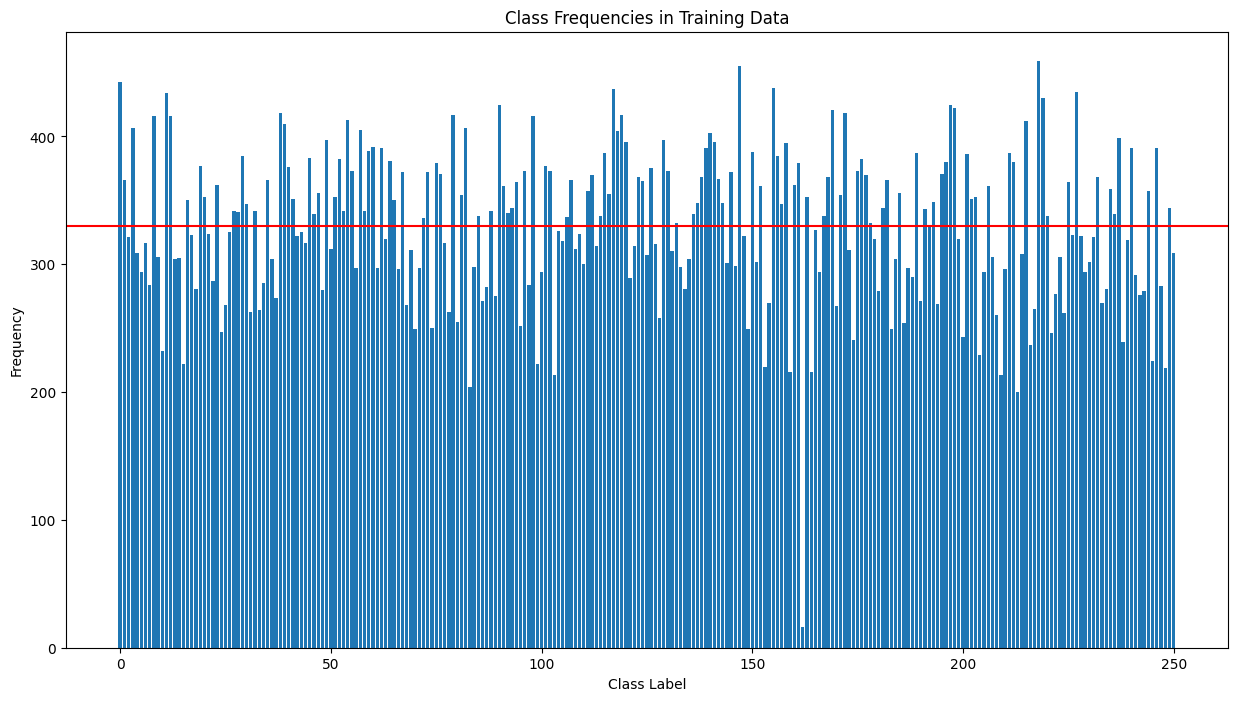

In [ ]:
# Bar plot of class frequencies
def plot_class_freqs(class_counts, ds='Training'):
    plt.figure(figsize=(15, 8))
    plt.bar(class_counts.index, class_counts.values)
    plt.axhline(y=avg_images_per_class, color='r', linestyle='-')
    plt.xlabel('Class Label')
    plt.ylabel('Frequency')
    plt.title(f'Class Frequencies in {ds} Data')
    plt.show()

plot_class_freqs(class_counts_train, 'Training')

In [ ]:
classes_below_mean_train = class_counts_train[class_counts_train < avg_images_per_class]
print(f"Classes with less images than the average (in the training set): {len(classes_below_mean_train)}")

Classes with less images than the average (in the training set): 121


## Data Balancing

> We downsample classes with more than 390 samples (118% of the average) and upsample those with fewer than 264 images (80% of the average).

In [ ]:
classes_to_upsample = class_counts_train[class_counts_train < 264]
classes_to_upsample

label
78     263
31     263
224    262
208    260
128    258
80     255
186    254
95     252
74     250
183    249
70     249
149    249
24     247
221    246
200    243
174    241
238    239
216    237
10     232
204    229
245    224
99     222
15     222
153    220
248    219
159    216
164    216
103    213
209    213
83     204
213    200
162     16
Name: count, dtype: int64

#### Downsample:

In [ ]:
# Downsample classes with more than max_samples images
max_samples = 390
dfs = []
print(f"Size before downsampling: {len(label_train)}")
for label, count in class_counts_train.items():
    df_label = label_train[label_train['label'] == label]
    if count > max_samples:
        df_label = df_label.sample(max_samples, random_state=42)
    dfs.append(df_label)

df_balanced = pd.concat(dfs)
print(f"Size after downsampling: {len(df_balanced)}")

Size before downsampling: 82932
Size after downsampling: 82013


We passed from 82,932 to 82,013 training samples.

In [ ]:
# Eliminate all content of the output directory
!rm -rf /kaggle/working/*

In [ ]:
# Create a directory to store the new images
os.makedirs('/kaggle/working/new_imgs')

#### Upsample:

> Instead of simply replicating images during upsampling, we apply various transformations such as rotation, flipping, color jitter, and cropping to create new, slightly altered versions of the existing images. This method not only increases the number of samples but also introduces variability that will help the models defined in the following step to generalize better.

In [ ]:
# Upsample classes with less than min_samples images
train_val_path = path + 'train_set/train_set/' # path to find the images
saving_path = '/kaggle/working/new_imgs/'      # path to save new images

min_samples = 264   # min number of samples for each class

# Define individual transformations
brightness = transforms.ColorJitter(brightness=0.5)
contrast = transforms.ColorJitter(contrast=0.5)
crop = transforms.RandomResizedCrop(size=(256, 256), scale=(0.8, 1.0))
gaussian_blur = transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))
rotation = transforms.RandomRotation(degrees=30)
perspective = transforms.RandomPerspective(distortion_scale=0.5, p=1.0)

# Compose the augmentations
augmentation_pipeline = transforms.Compose([
    transforms.RandomApply([brightness], p=0.5),
    transforms.RandomApply([contrast], p=0.5),
    transforms.RandomApply([crop], p=0.5),
    transforms.RandomApply([gaussian_blur], p=0.5),
    transforms.RandomApply([rotation], p=0.5),
    transforms.RandomApply([perspective], p=0.5),
    # transforms.ToTensor()
])

# Apply augmentation to the image
def augment_image(img_path, augm):
    image = Image.open(img_path)
    return augm(image)

dfs = []

for label, count in class_counts_train.items():
    df_label = df_balanced[df_balanced['label'] == label]
    if count < min_samples:
        # Get number of new samples to generate
        n_needed = min_samples - count
        augment_names = []
        for i in range(n_needed):
            # Select random image of the current class to replicate
            img_name = random.choice(df_label['img_name'].tolist())
            img_path = train_val_path + img_name
            # Generate augmented image
            augmented_img = augment_image(img_path, augmentation_pipeline)
            # Save augmented image to a new path
            new_img_name = f'new{i}_{img_name}'
            augmented_img.save(saving_path + new_img_name)
            augment_names.append(new_img_name)

        # Add augmented img names to the dataframe
        new_df = pd.DataFrame({'img_name': augment_names, 'label': label})
        df_label = pd.concat([df_label, new_df])

    dfs.append(df_label)

df_balanced = pd.concat(dfs)
print(f"Size after upsampling: {len(df_balanced)}")

Size after downsampling: 83098


We passed from 82,013 to 83,098 training samples.

## Visualizations

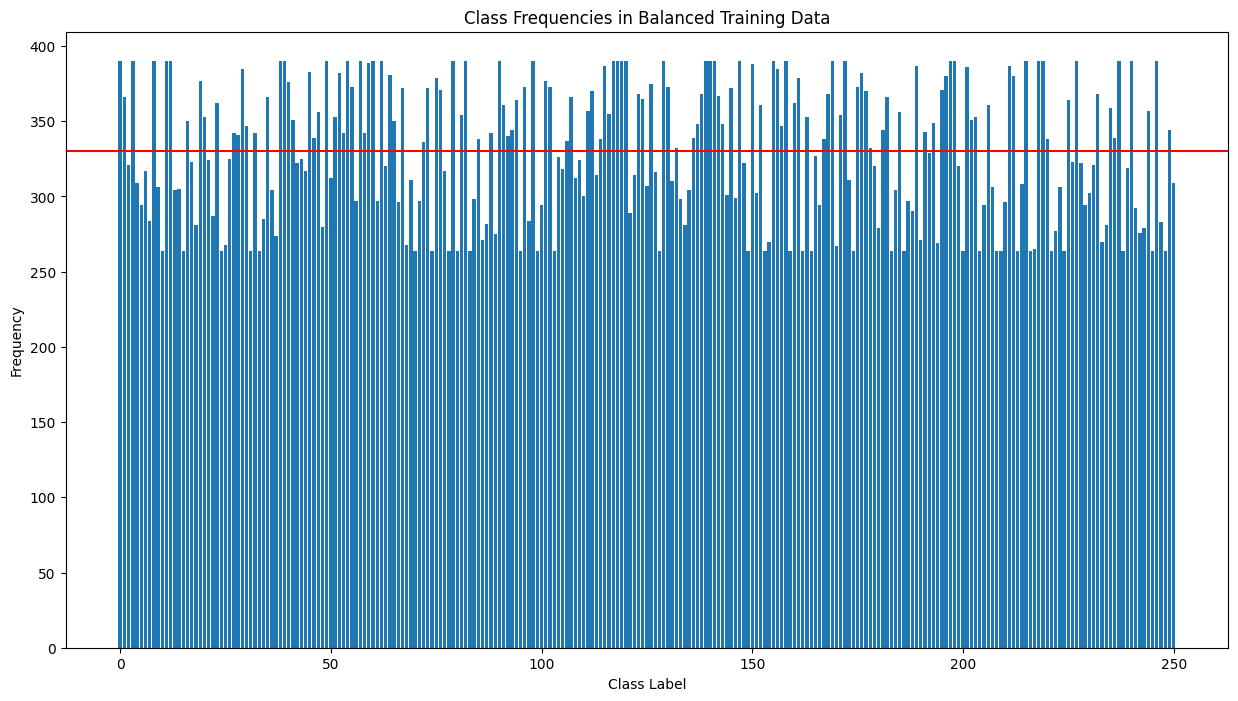

In [ ]:
# Bar plot of class frequencies for the balanced training set
new_class_counts_train = df_balanced['label'].value_counts()
plot_class_freqs(new_class_counts_train, 'Balanced Training')

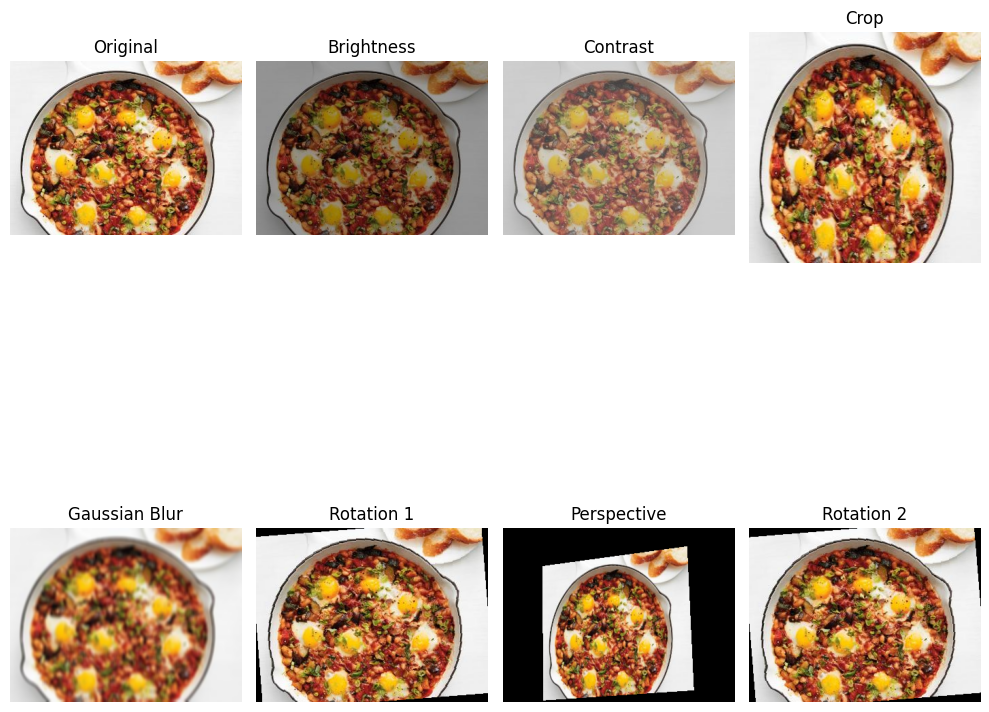

In [ ]:
# Visualization of the transformations we employed

def show_augmented_images(df_balanced, train_val_path):
    # Extract a random image from the dataframe
    random_row = df_balanced.sample(n=1).iloc[0]
    img_name = random_row['img_name']
    img_path = os.path.join(train_val_path, img_name)

    # Open the original image
    original_image = Image.open(img_path)

    # Define individual transformations
    brightness = transforms.ColorJitter(brightness=0.5)
    contrast = transforms.ColorJitter(contrast=0.5)
    crop = transforms.RandomResizedCrop(size=(256, 256), scale=(0.8, 1.0))
    gaussian_blur = transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))
    rotation = transforms.RandomRotation(degrees=30)
    perspective = transforms.RandomPerspective(distortion_scale=0.5, p=1.0)

    # Apply transformations individually
    transformations = [
        original_image,
        brightness(original_image),
        contrast(original_image),
        crop(original_image),
        gaussian_blur(original_image),
        rotation(original_image),
        perspective(original_image),
        rotation(original_image),  # Just to make them 8, more visually pleasant
    ]

    # Plot the original and augmented images
    fig, axs = plt.subplots(2, 4, figsize=(10, 12))
    axs = axs.ravel()

    titles = ['Original', 'Brightness', 'Contrast', 'Crop',
              'Gaussian Blur', 'Rotation 1', 'Perspective', 'Rotation 2']

    for i in range(8):
        axs[i].imshow(transformations[i])
        axs[i].set_title(titles[i])
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()


show_augmented_images(df_balanced, train_val_path)

## Save Preprocessed Data

In [ ]:
# Save the balanced training dataframe
df_balanced.to_csv('/kaggle/working/balanced_trainset.csv', index=False)

In [ ]:
# Save the validation dataframe
label_val.to_csv('/kaggle/working/valset.csv', index=False)

In [ ]:
# Create a zip directory to export the newly created images
import zipfile
from IPython.display import FileLink

def zip_dir(directory = '/kaggle/working', file_name = 'new_imgs.zip'):
    os.chdir(directory)
    zip_ref = zipfile.ZipFile(file_name, mode='w')
    for folder, _, files in os.walk(directory):
        for file in files:
            if file_name in file:
                pass
            else:
                zip_ref.write(os.path.join(folder, file))

    return FileLink(file_name)

In [ ]:
zip_dir()

/kaggle/working/new_imgs.zip